1


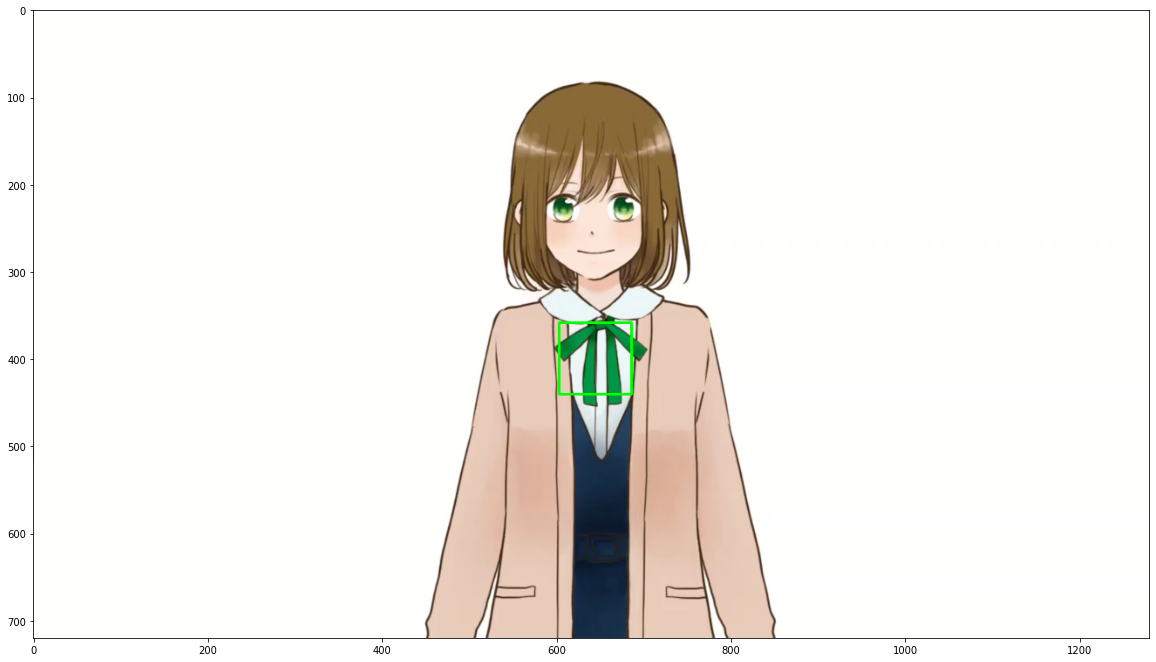

2


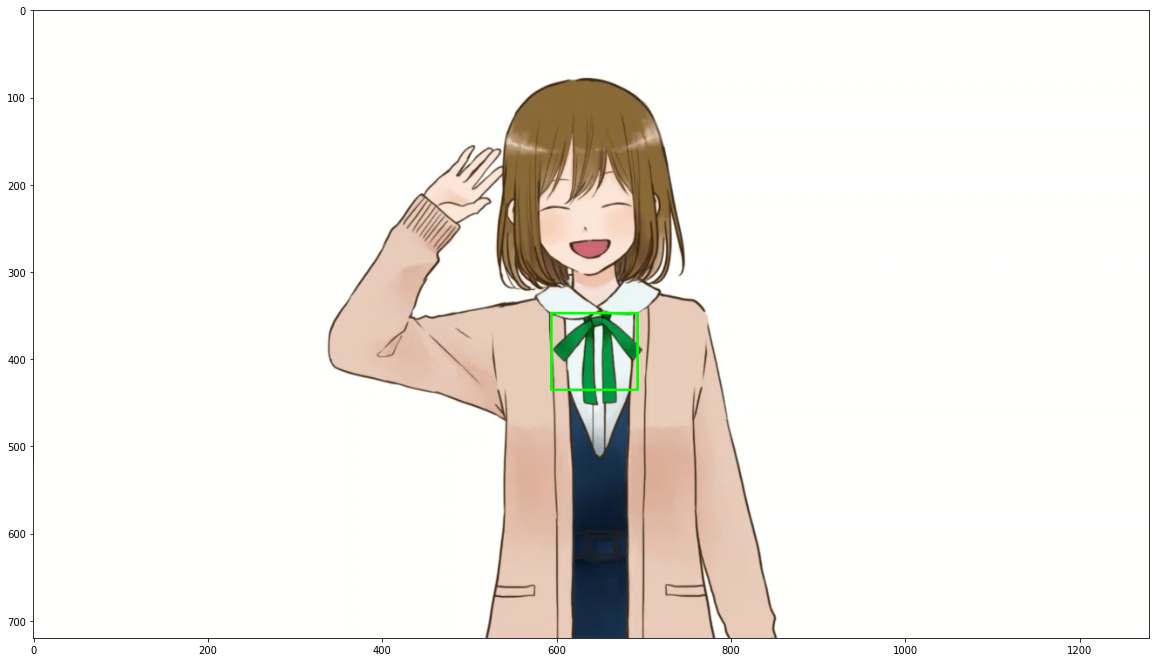

3


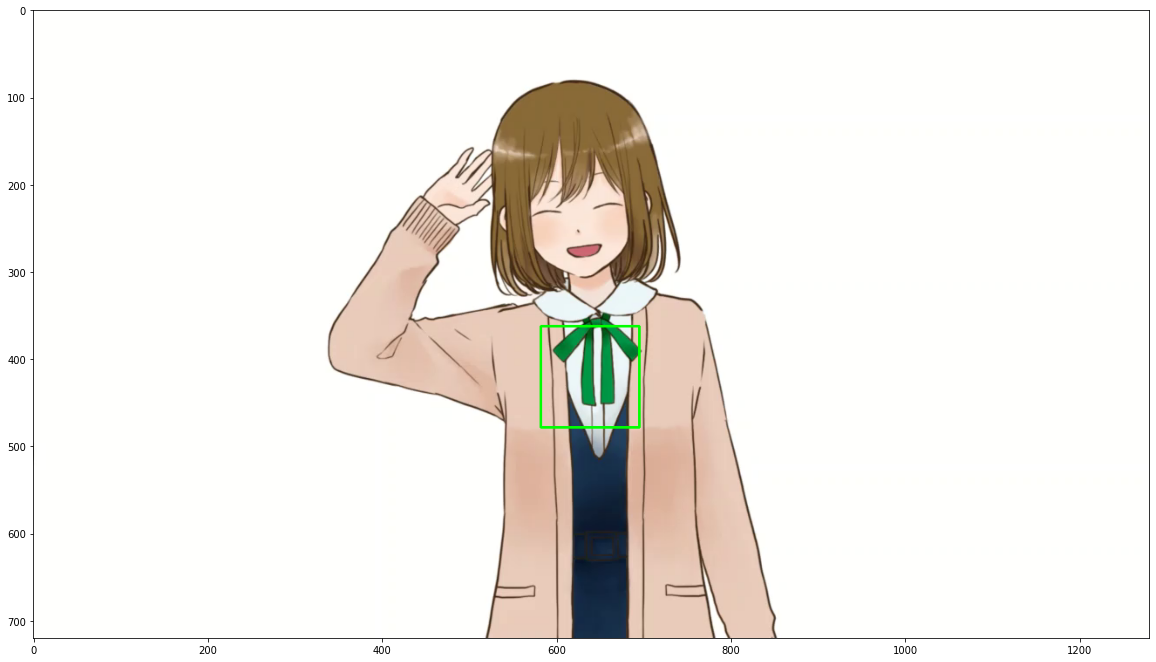

4


KeyboardInterrupt: ignored

In [19]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image

# cap=cv2.VideoCapture('1-2.mp4')
# if not cap.isOpened:
#     print('wrong')
# else:
#     print('good')

# fmt = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
# fps = cap.get(cv2.CAP_PROP_FPS)
# size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
# writer = cv2.VideoWriter('outtest.mp4', fmt, fps, size)

temp = []
for i in range(5):
    temp.append(cv2.imread('new_temp_'+str(i+1)+'.png'))

# temp.append(cv2.imread('new_temp_5-2.png'))
# print(temp[4].shape)

# 服の色がindex0, 白がindex1
cols=[[233, 203, 186],[235, 248, 247], [105, 75, 58]]

for num in range(1,  206):
    print(num)
    img=Image.open('teacher_imgs-'+str(num)+'.png')
    img=np.array(img)

    can_use=np.zeros((1,4))
    for i in range(len(temp)):
        res = cv2.matchTemplate(img,temp[i],cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        h, w, _=temp[i].shape
        x=int(max_loc[0]+w)
        y=int(max_loc[1]+h)

        box_beg_x=x-int(w/13*9)
        box_beg_y=y-int(h/35*9)
        box_fin_x=x-int(w/13*4)
        box_fin_y=y
        beg_x=max_loc[0]
        beg_y=max_loc[1]
        fin_x=max_loc[0]+w
        fin_y=max_loc[1]+h
        width=box_fin_x-box_beg_x

        passed=True
        for H in range(3):
            new_col=[]
            new_cnt=np.zeros(100)
            cols_cnt=np.zeros(len(cols))
            box_cols_cnt=np.zeros(len(cols))
            for k in range(beg_x, fin_x):
                color=img[fin_y-H-2][k].astype('int64')
                different=True
                for a in range(len(cols)):
                    cc=0
                    for b in range(3):
                        cc+=abs(color[b]-cols[a][b])
                    if cc<=40:                                       
                        if box_beg_x<=k and k<=box_fin_x:
                            box_cols_cnt[a]+=1      
                        cols_cnt[a]+=1
                        different=False
                if different:
                    diff=True
                    for a in range(len(new_col)):
                        count=0
                        for b in range(3):
                            count+=abs(color[b]-new_col[a][b])
                        if count<=50:
                            diff=False
                            new_cnt[a]+=1        
                    if diff:
                        new_col.append(color)
                        new_cnt[len(new_col)]+=1
            bluenum=0
            blue=[51, 72, 93]
            for c in range(len(new_col)):
                col_diff=0
                for k in range(3):
                    col_diff+=abs(new_col[c][k]-blue[k])
                if col_diff<=40:
                    bluenum=max(bluenum, new_cnt[c])
            ratio_hada=box_cols_cnt[0]/width
            ratio_white=box_cols_cnt[1]/width
            new_cnt=np.sort(new_cnt)[::-1]
            if new_cnt[0]<8 or cols_cnt[0]<12 or cols_cnt[1]<12 or bluenum>20 or ratio_hada>0.5 or ratio_white>0.5:   
                passed=False
                break
        if passed:
            can_use=np.vstack([can_use, np.array([box_beg_x, box_beg_y, box_fin_x, box_fin_y])])

        # cv2.rectangle(img, max_loc, (max_loc[0]+w, max_loc[1]+h), (255, 0, 0), 2)
        # cv2.putText(img, str(i+1), (max_loc[0], max_loc[1]-10), font, 1, (0, 255, 0), 1, cv2.LINE_AA)

    can_use=can_use[np.argsort(can_use[:, 3])[::-1]].astype('uint16')

    beg_x=can_use[0][0]
    beg_y=can_use[0][1]
    fin_x=can_use[0][2]
    fin_y=can_use[0][3]

    height=int((beg_y+fin_y)/2)
    new_col={}
    for yoko in range(beg_x, fin_x):
        cnt=0
        color=img[height][yoko].astype('int16')
        for k in range(3):
            cnt+=255-img[height][yoko][k] 
        if cnt>=100:
            diff=True
            for col in new_col:
                count=0
                for b in range(3):
                    count+=abs(color[b]-col[b])
                if count<=50:
                    diff=False
                    new_col[col]+=1        
            if diff:
                new_col[tuple(color)]=1
    new_col=sorted(new_col.items(), key=lambda x: x[1], reverse=True)

    ok=False
    for index, col in enumerate(new_col):
        cnt=0
        green=[3, 151, 68]
        for k in range(3):
            cnt+=abs(green[k]-col[0][k])
        if cnt<=60:
            ok=True
    if ok:
        cv2.rectangle(img, (beg_x, beg_y), (fin_x, fin_y), (0, 255, 0), 2)
    else:
        cv2.rectangle(img, (beg_x, beg_y), (fin_x, fin_y), (255, 0, 0), 2)

    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.show()

    # writer.write(img)

# writer.release()
# cap.release()
# cv2.destroyAllWindows()

# [233 203 186]    服の色
# [235 248 247]    間の白の色